In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import scipy.stats
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1,
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)

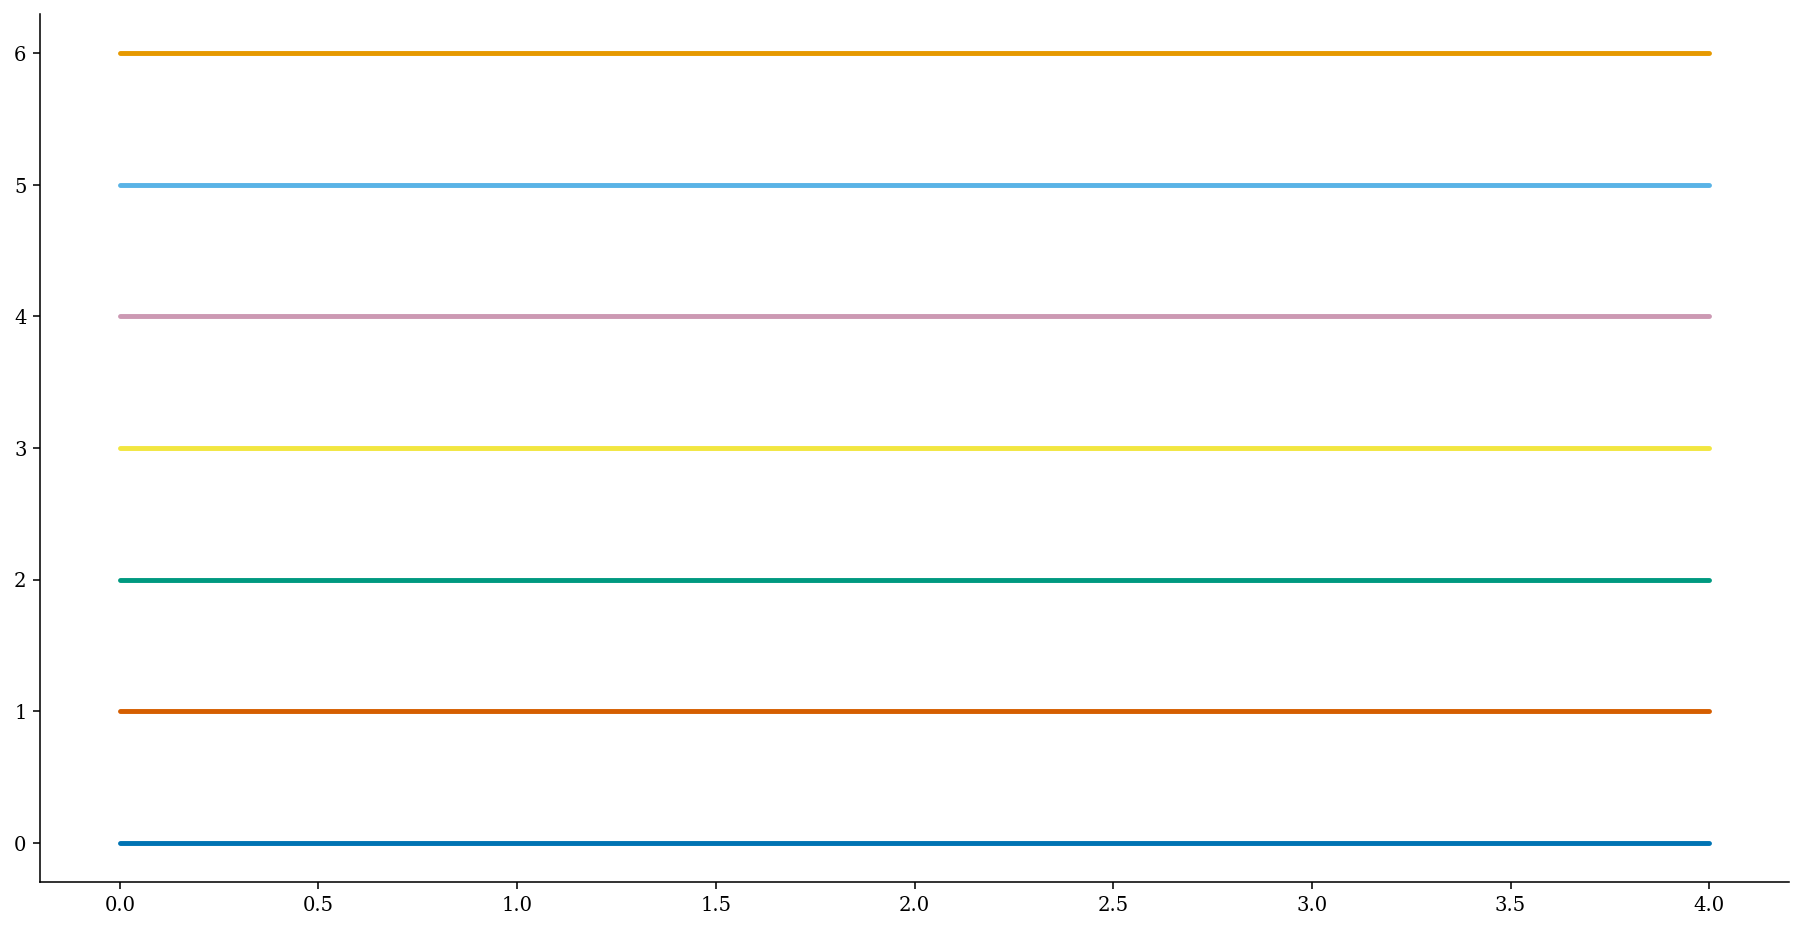

In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'medium'
rcParams['axes.titlesize'] = 'large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'small'
rcParams['ytick.labelsize'] = 'small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
for i,c in enumerate(colorblind_colors):
    plt.plot((i)*np.ones(5),c=c)

In [33]:
## orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
# test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
orig_data_path = "/projects/EKOLEMEN/profile_predictor/DATA/rotation_km_toksearch/new_shots.pkl"

traindata, valdata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      ["zipfit_trotfit", "cer_rot_csaps_1d"],
                                                      "RobustScaler",
                                                      1,
                                                      0,
                                                      {"zipfit_trotfit": 0, "cer_rot_csaps_1d": 0},
                                                      0,
                                                      1,
                                                      True,
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      12000,
                                                      2, #scenario['verbose']
                                                      True,
                                                      randomize=False,
                                                      pruning_functions=['remove_nan',
                                             'remove_dudtrip',
                                             'remove_I_coil',
                                             'remove_non_gas_feedback',
#                                              'remove_non_beta_feedback',
                                             'remove_ECH'],
                                                      excluded_shots =  ['topology_TOP', 
                                           'topology_OUT',
                                           'topology_MAR',
                                           'topology_IN',
                                           'topology_DN',
                                           'topology_BOT',
                                           'test_set'],
                                                      delta_sigs = [],
                                                      invert_q=True,
                                                      val_idx = 0)



Loading
Signals: cer_rot_csaps_1d, zipfit_trotfit
Number of useable shots:  3557
Number of shots used:  3557
Total number of timesteps:  426840
Shots with Complete NaN: 
423283 samples total
Removing ECH
Removed 146104 samples
277179 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 54110 samples
223069 samples remaining
Removing weird I-coils
Removed 48803 samples
174266 samples remaining
Removing NaN
Removed 0 samples
174266 samples remaining
Removing dudtrip
Removed 4999 samples
169267 samples remaining
169267 samples remaining after pruning
Total number of samples:  169267
Number of training samples:  152676
Number of validation samples:  16591


In [34]:
traindata = helpers.normalization.denormalize(traindata.copy(),normalization_dict)

Denormalizing: 100%|##########| 11/11 [00:00<00:00, 235.11it/s]


In [36]:
zipfit = traindata["zipfit_trotfit"].squeeze()
csaps = traindata["cer_rot_csaps_1d"].squeeze()

In [38]:
zipfitn, zipfit_params = helpers.normalization.normalize(zipfit, "RobustScaler")

In [39]:
zipfit_params

{'nanmean': 34.830494,
 'method': 'RobustScaler',
 'median': 25.164951,
 'iqr': 54.9990119934082}

In [62]:
model([0,1])

4424543.0

In [58]:
model([5,5])

884675.5

In [56]:
def model(x):
    mean = x[0]
    std = x[1]
    cs = (csaps-mean)/std
    return np.linalg.norm((cs-zipfitn).flatten())

In [67]:
out = scipy.optimize.minimize(model, x0=[0, 1], tol=-1, options={"maxiter":10})

/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-pack

f = $||Z-(C-m)/s||^2$

$z = C*(1/s) +1*(-m)/s$


In [98]:
A = np.array([csaps.flatten(), -np.ones_like(csaps).flatten()]).T
b = zipfitn.flatten()

beta = np.linalg.lstsq(A,b, rcond=None)

In [99]:
s = 1/beta[0][0]
m = beta[0][1]*s

In [100]:
s, m

(122.47815127133575, 50.7268047428464)

In [90]:
np.median(zipfit)

25.164951

In [94]:
med = np.median(csaps)
iqr = np.percentile(csaps, 75) - np.percentile(csaps, 25)

outliers = np.where(np.logical_or(csaps>med + 3*iqr, csaps<med-3*iqr))

In [97]:
csaps[outliers] = med

In [101]:
csapsn = (csaps-m)/s

In [ ]:
fig, ax = plt.subplots(1,2, squeeze=True)

k = 2000
ax[0].plot(zipfit[k,:])
ax[0].plot(csaps[k,:])
ax[0].set_title("Raw")

ax[1].plot(zipfitn[k,:])
ax[1].plot(csapsn[k,:])
ax[1].set_title("Normalized")



Text(0.5, 1.0, 'Normalized')

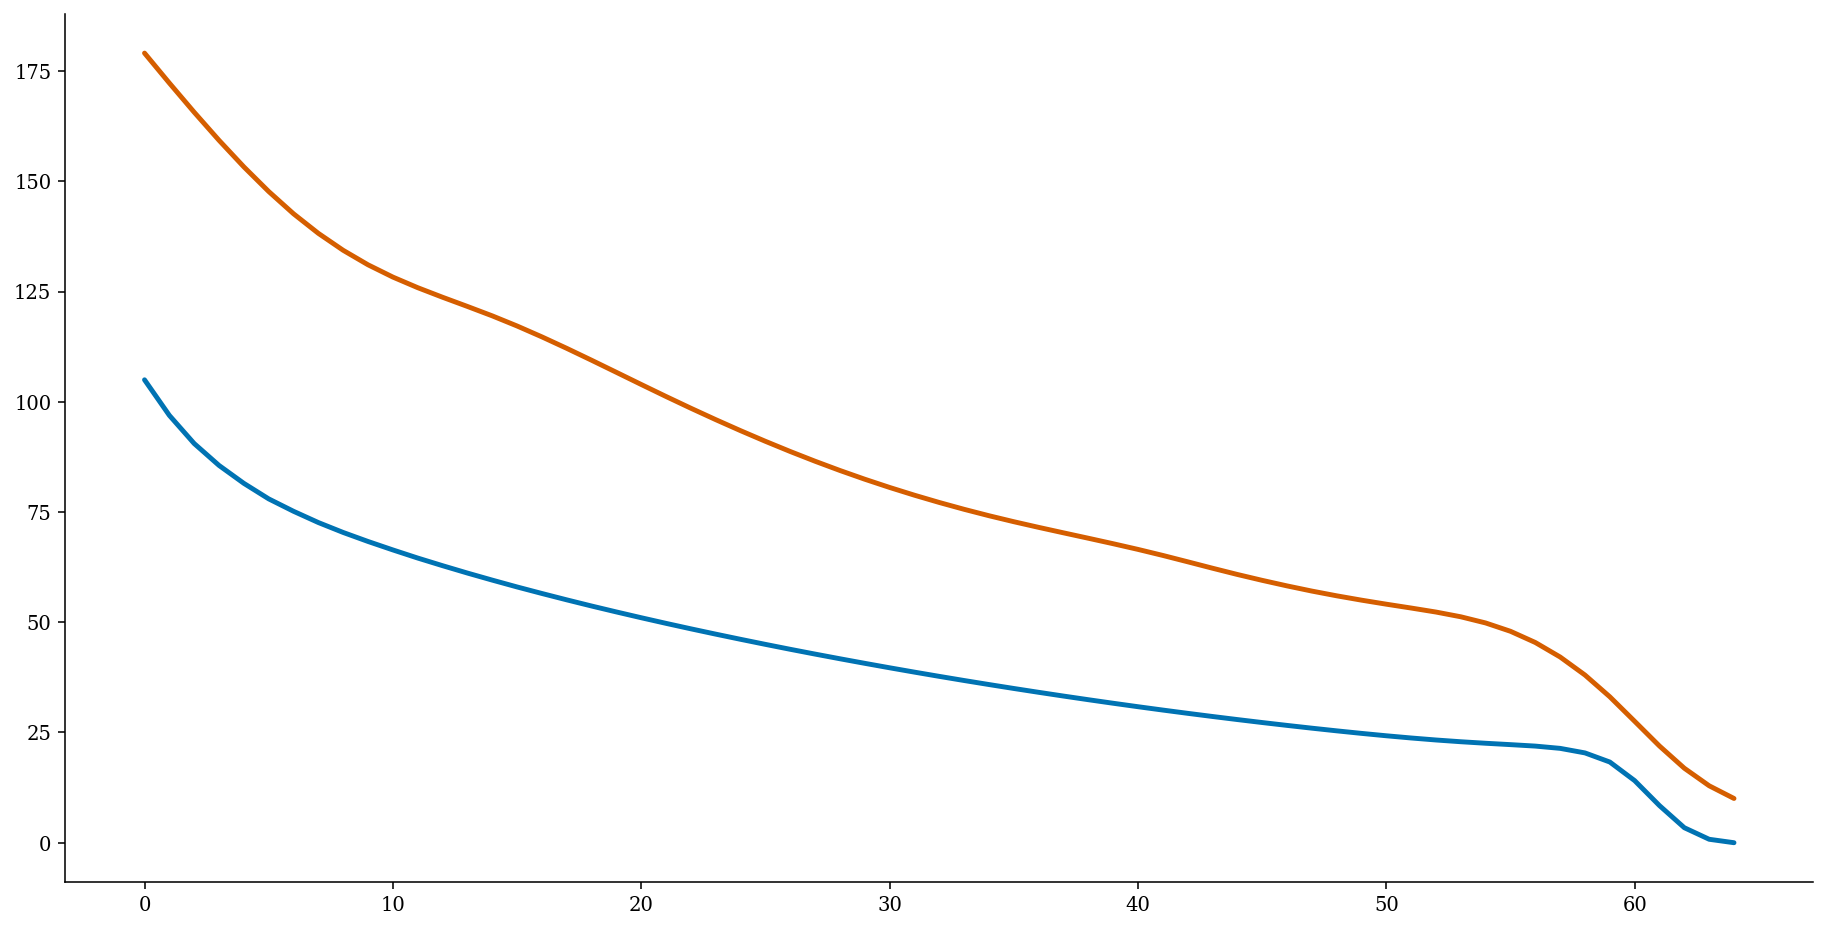

In [105]:
plt.plot(zipfit[500,:])
plt.plot(csaps[500,:])